In [52]:
options("stringsAsFactors" = FALSE)
library(phateR)
library(monocle)
library(scater)
library(knitr)
library(reshape2)
library(ggplot2)
library(stringr)
library(pheatmap)
library(Matrix)
library(Seurat)
library(plyr)
library(stringr)
library(pheatmap)
library(biomaRt)
library(GenomicFeatures)
library(pracma)
library(scran)
library(ggpubr)
library(clusterProfiler)
library(enrichplot)
library(dplyr)
library(Hmisc)
library(corrplot)
library(Rgraphviz)
library(circlize)
library(Rgraphviz)
library(networkD3)
library(gridExtra)
library(ggsci)
library(future)
library(pheatmap)


Attaching package: 'networkD3'


The following object is masked from 'package:Seurat':

    JS



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:Biobase':

    combine


The following object is masked from 'package:BiocGenerics':

    combine



Attaching package: 'future'


The following object is masked from 'package:survival':

    cluster


The following object is masked from 'package:SummarizedExperiment':

    values


The following object is masked from 'package:GenomicRanges':

    values


The following object is masked from 'package:IRanges':

    values


The following object is masked from 'package:S4Vectors':

    values




In [53]:
ensembleID2genename <- read.table(file = "genecodename_genesymbol.txt", header = F)%>%unique() #/data02/zywang/HuiCheng/data/utilData/

colnames(ensembleID2genename) <- c('ensemblID', 'geneName')
ensembleID2genename$capitalGeneName <- toupper(ensembleID2genename[,2])

ensembleID2genename$ensemblIDNoDot <- ensembleID2genename$ensemblID
for(i in 1:nrow(ensembleID2genename)){
    ensembleID2genename[i,4] <- str_split(ensembleID2genename[i,4], pattern = "\\.")[[1]][1]
}

head(ensembleID2genename)

,ensemblID,geneName,capitalGeneName,ensemblIDNoDot
,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000102693.1,4933401J01Rik,4933401J01RIK,ENSMUSG00000102693
4,ENSMUSG00000064842.1,Gm26206,GM26206,ENSMUSG00000064842
7,ENSMUSG00000051951.5,Xkr4,XKR4,ENSMUSG00000051951
25,ENSMUSG00000102851.1,Gm18956,GM18956,ENSMUSG00000102851
28,ENSMUSG00000103377.1,Gm37180,GM37180,ENSMUSG00000103377
31,ENSMUSG00000104017.1,Gm37363,GM37363,ENSMUSG00000104017


In [67]:
FilePath = "C://Users//gaojx//Desktop//JumpDiffusion//"

In [69]:
ES_d0_matrix <- read.csv(paste(FilePath,'GSM1599494_ES_d0_main.csv',sep=""), header = FALSE, row.names = 1)

In [70]:
ES_d0 <- CreateSeuratObject(counts = ES_d0_matrix,
                              project = 'D0',
                              min.cells = 10,
                              min.feature = 200)

In [72]:
ES_d2_matrix <- read.csv(paste(FilePath,'GSM1599497_ES_d2_LIFminus.csv',sep=""), header = FALSE, row.names = 1)

In [73]:
ES_d2 <- CreateSeuratObject(counts = ES_d2_matrix,
                              project = 'D2',
                              min.cells = 10,
                              min.feature = 200)

In [74]:
ES_d4_matrix <- read.csv(paste(FilePath,'GSM1599498_ES_d4_LIFminus.csv',sep=""), header = FALSE, row.names = 1)

In [75]:
ES_d4 <- CreateSeuratObject(counts = ES_d4_matrix,
                              project = 'D4',
                              min.cells = 10,
                              min.feature = 200)

In [76]:
ES_d7_matrix <- read.csv(paste(FilePath,'GSM1599499_ES_d7_LIFminus.csv',sep=""), header = FALSE, row.names = 1)

In [77]:
ES_d7 <- CreateSeuratObject(counts = ES_d7_matrix,
                              project = 'D7',
                              min.cells = 10,
                              min.feature = 200)

In [78]:
merge_object <- merge(x = ES_d0, y = list(ES_d2, ES_d4, ES_d7),
                     add.cell.ids = c('D0', 'D2', 'D4', 'D7'))

In [79]:
head(merge_object@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA
,<chr>,<dbl>,<int>
D0_V2,D0,39366,14195
D0_V3,D0,44270,15329
D0_V4,D0,46655,15054
D0_V5,D0,30461,12729
D0_V6,D0,13396,7455
D0_V7,D0,46953,15912


In [80]:
ctrl_object <- merge_object

# 数据预处理

In [81]:
ctrl_object[["percent.mt"]] <- PercentageFeatureSet(ctrl_object, pattern = "^Mt-")

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of percent.mt."


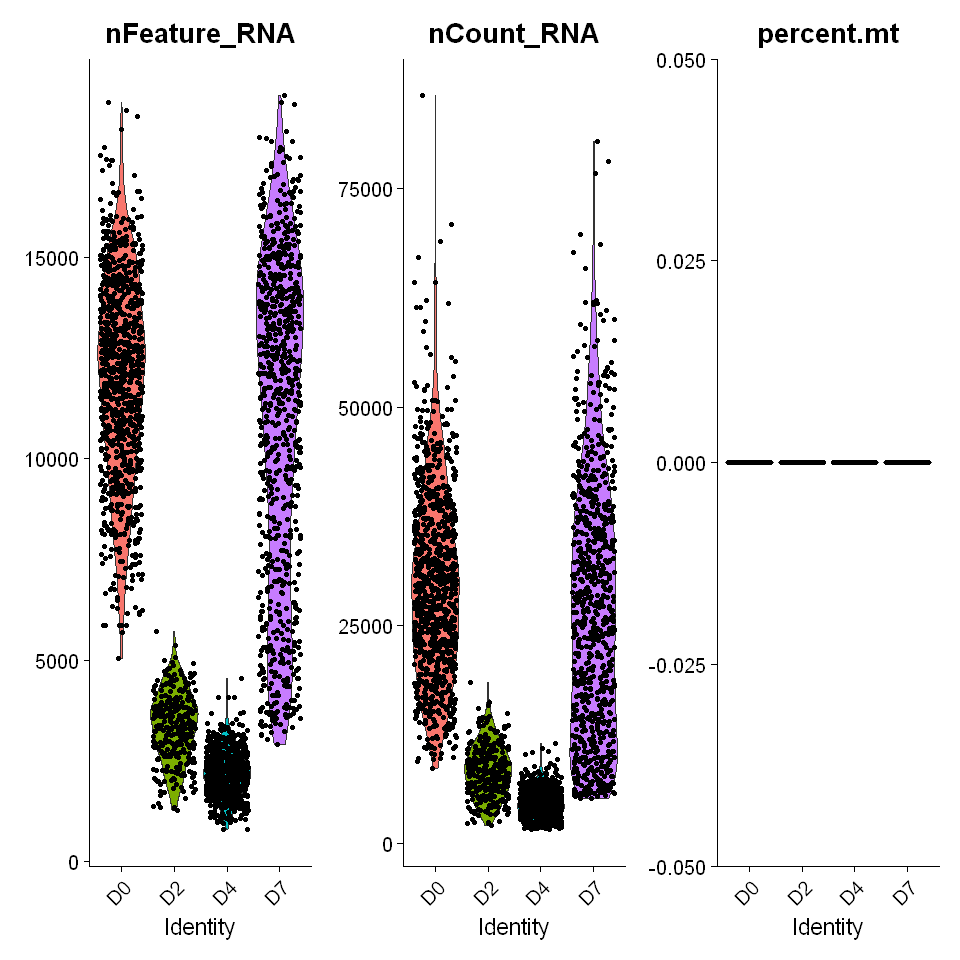

In [82]:
VlnPlot(ctrl_object, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

Warning message in cor(x = data[, 1], y = data[, 2]):
"标准差为零"
Warning message:
"CombinePlots is being deprecated. Plots should now be combined using the patchwork system."


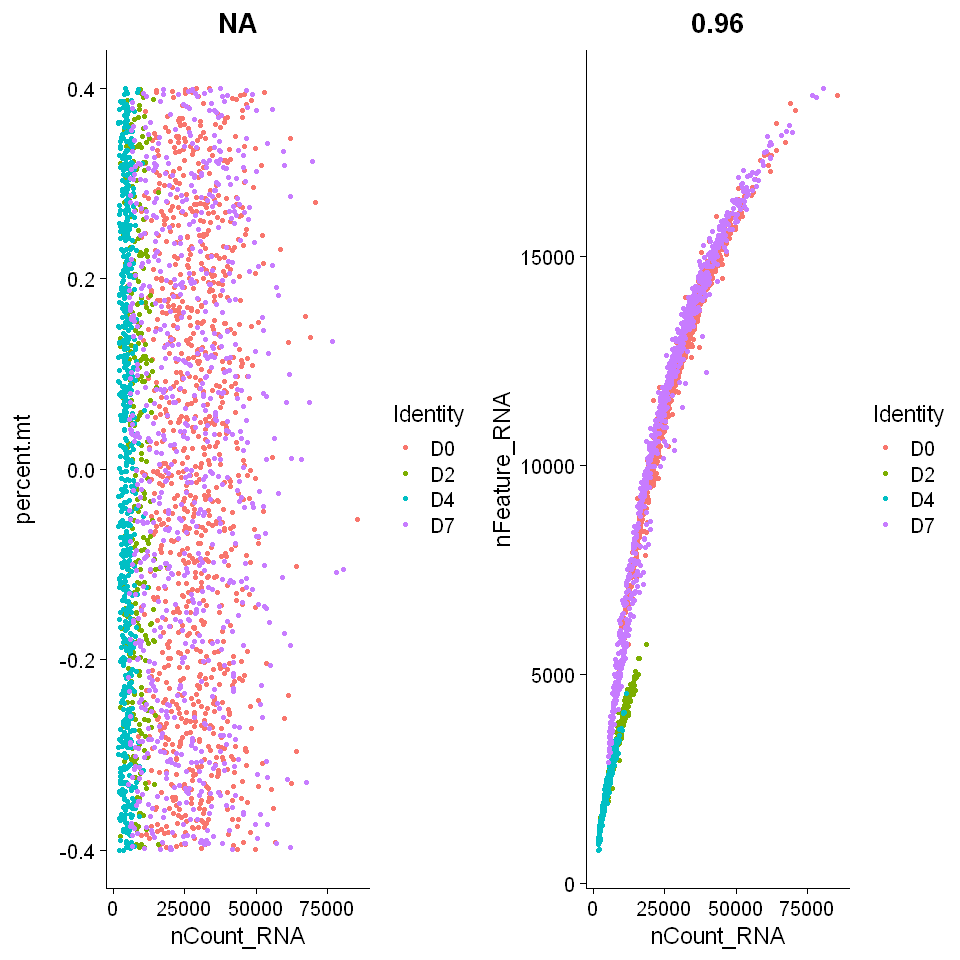

In [83]:
ctrl_objectplot1 <- FeatureScatter(ctrl_object, feature1 = "nCount_RNA", feature2 = "percent.mt")
ctrl_objectplot2 <- FeatureScatter(ctrl_object, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
CombinePlots(plots = list(ctrl_objectplot1, ctrl_objectplot2))

In [84]:
#ctrl_object <- subset(ctrl_object, subset = nFeature_RNA > 200 & percent.mt < 20)
ctrl_object <- NormalizeData(ctrl_object, normalization.method = "LogNormalize", scale.factor = 10000)

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."
When using repel, set xnudge and ynudge to 0 for optimal results



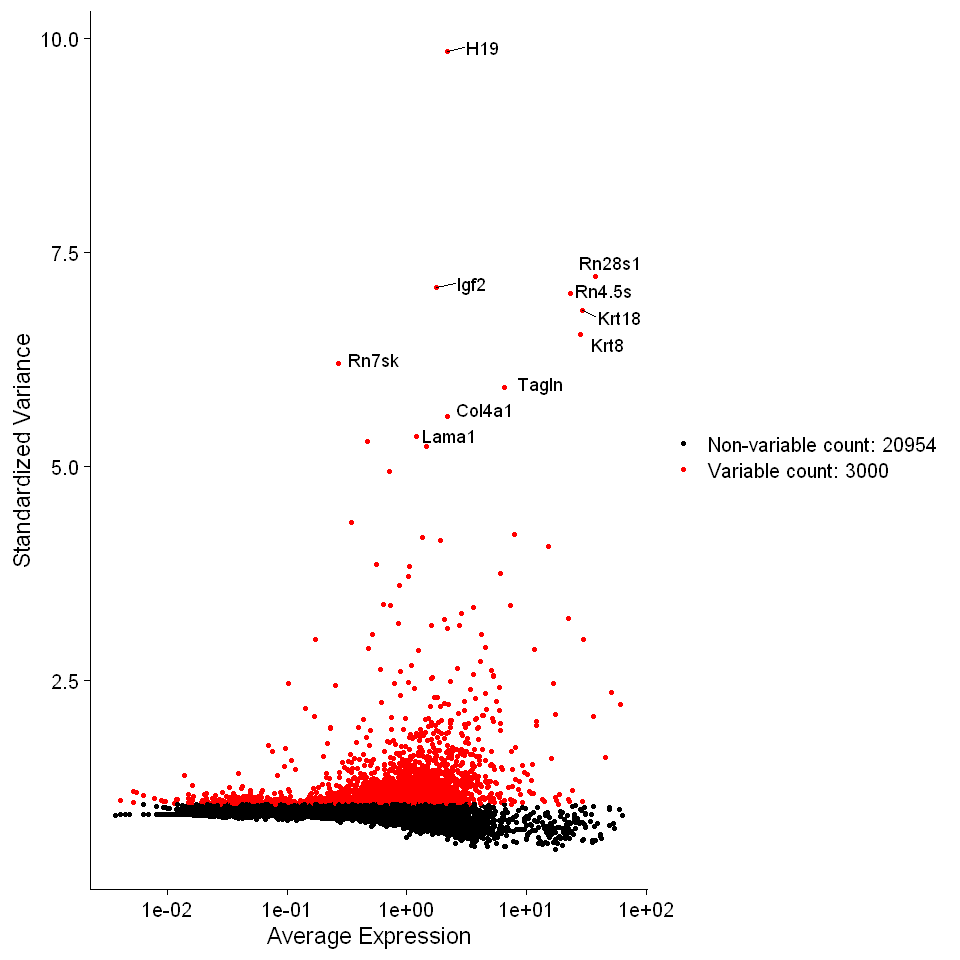

In [85]:
ctrl_object <- FindVariableFeatures(ctrl_object, selection.method = "vst", nfeatures = 3000)
# Identify the 10 most highly variable genes
ctrl_objecttop10 <- head(VariableFeatures(ctrl_object), 10)
# plot variable features with and without labels
ctrl_objectplot1 <- VariableFeaturePlot(ctrl_object)
ctrl_objectplot2 <- LabelPoints(plot = ctrl_objectplot1, points = ctrl_objecttop10, repel = TRUE)
ctrl_objectplot2

In [86]:
ctrl_object <- ScaleData(ctrl_object, features = rownames(ctrl_object) ,vars.to.regress =  NULL)

Centering and scaling data matrix



In [87]:
ctrl_object <- RunPCA(ctrl_object, features = VariableFeatures(object = ctrl_object), verbose=FALSE)

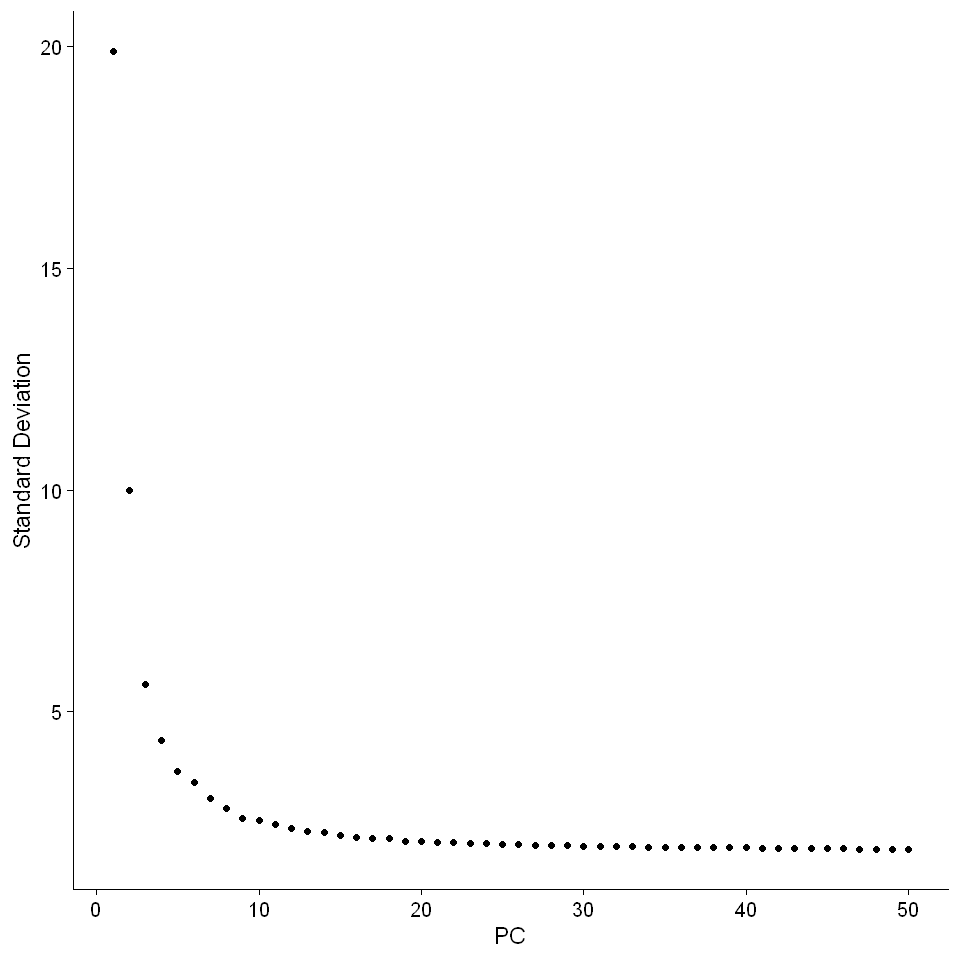

In [88]:
ElbowPlot(ctrl_object,ndims = 50)

## Cluster the cells

In [89]:
ctrl_object <- FindNeighbors(ctrl_object, dims = 1:10)
ctrl_object <- FindClusters(ctrl_object, resolution = 0.2)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2717
Number of edges: 97118

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9448
Number of communities: 6
Elapsed time: 0 seconds


## Run non-linear dimensional reduction (UMAP/tSNE)

In [90]:
ctrl_object <- RunUMAP(object = ctrl_object, reduction = "pca", dims=1:10,
                           n.neighbors=50L)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
18:40:04 UMAP embedding parameters a = 0.9922 b = 1.112

18:40:04 Read 2717 rows and found 10 numeric columns

18:40:04 Using Annoy for neighbor search, n_neighbors = 50

18:40:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:40:04 Writing NN index file to temp file C:\Users\gaojx\AppData\Local\Temp\Rtmp6FCx7X\file224451573f87

18:40:04 Searching Annoy index using 1 thread, search_k = 5000

18:40:05 Annoy recall = 100%

18:40:06 Commencing smooth kNN distance calibration using 1 thre

In [91]:
ctrl_object <- RunTSNE(object = ctrl_object, reduction = "pca", dims=1:10,
                           n.neighbors=50L)

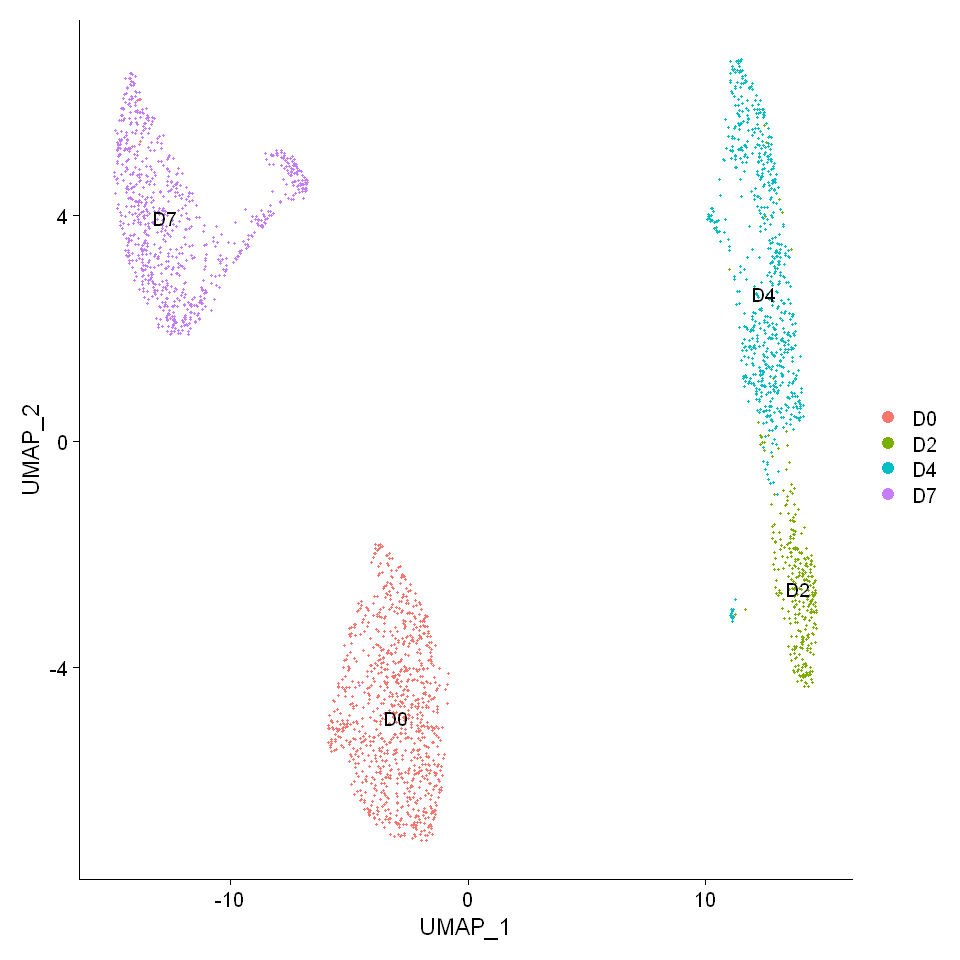

In [92]:
DimPlot(ctrl_object, reduction = "umap", label = TRUE, pt.size = 0.5, group.by='orig.ident') 

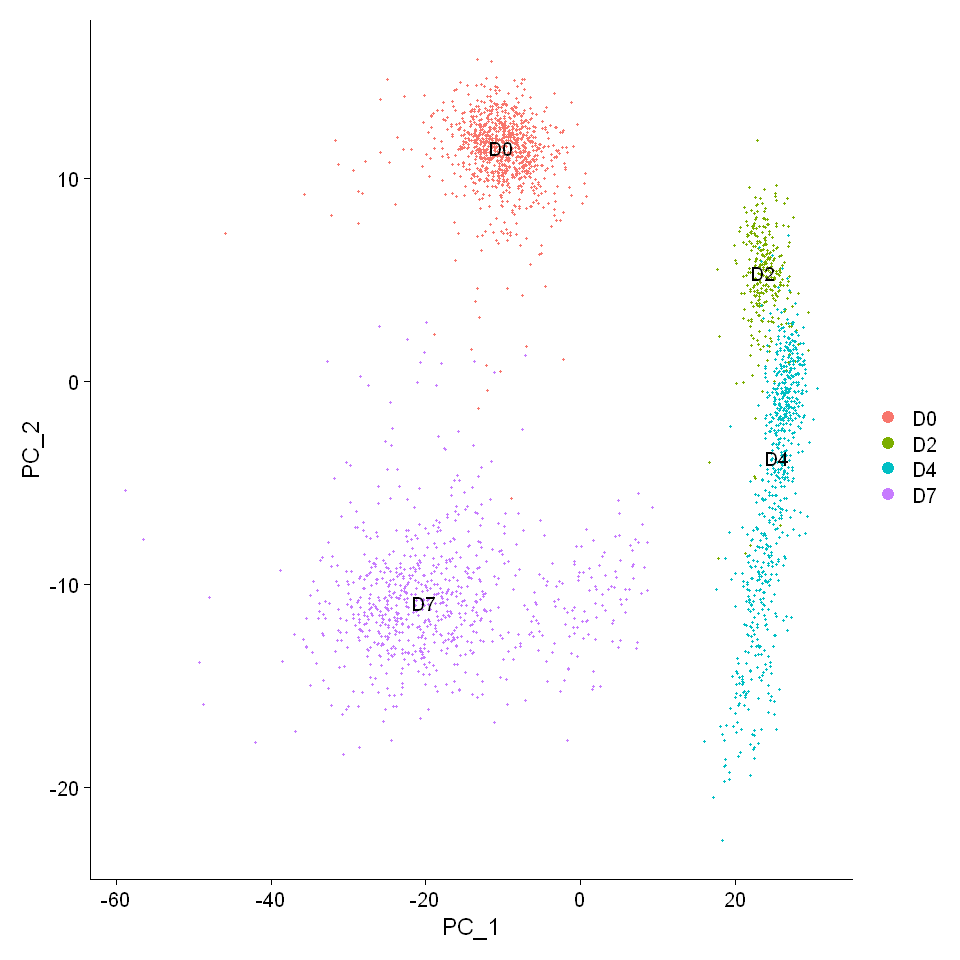

In [93]:
DimPlot(ctrl_object, reduction = "pca", label = TRUE, pt.size = 0.5, group.by='orig.ident') 

# 用monocle看分化

In [94]:
d0_matrix <- read.table('d0.txt', header = FALSE, sep=',')
d2_matrix <- read.table('d2.txt', header = FALSE, sep=',')
d4_matrix <- read.table('d4.txt', header = FALSE, sep=',')
d7_matrix <- read.table('d7.txt', header = FALSE, sep=',')

In [95]:
d0247_matrix <- cbind(d0_matrix, d2_matrix)
d0247_matrix <- cbind(d0247_matrix, d4_matrix)
d0247_matrix <- cbind(d0247_matrix, d7_matrix)

In [96]:
geneNames <- read.table('./geneNames.txt')

In [97]:
rownames(d0247_matrix) <- geneNames[,1]

In [98]:
colnames(d0247_matrix) <- c(paste('D0',1:ncol(d0_matrix),sep='_'),paste('D2',1:ncol(d2_matrix),sep='_'),paste('D4',1:ncol(d4_matrix),sep='_'),paste('D7',1:ncol(d7_matrix),sep='_'))

In [99]:
gene_metadata <- as.data.frame(rownames(d0247_matrix))

In [100]:
rownames(gene_metadata) <- gene_metadata[,1]
gene_metadata $ ensembleID <- mapvalues(x = gene_metadata[,1], 
                                            from = ensembleID2genename$geneName, 
                                            to = ensembleID2genename$ensemblIDNoDot,
                                            warn_missing = FALSE) 
colnames(gene_metadata) <- c('gene_short_name','ensembleID')

In [101]:
cell_metadata <- as.data.frame(colnames(d0247_matrix))
rownames(cell_metadata) <- cell_metadata[,1]

In [117]:
cell_metadata$Day <-  c(rep('D0',ncol(d0_matrix)),rep('D2',ncol(d2_matrix)),rep('D4',ncol(d4_matrix)),rep('D7',ncol(d7_matrix)))

In [118]:
##
# monocleobject <- newCellDataSet(GetAssayData(object = merge_object, slot = "counts"),
#                                     phenoData =  new("AnnotatedDataFrame", data = merge_object@meta.data),
#                                     featureData =  new("AnnotatedDataFrame", data = gene_metadata),
#                                     lowerDetectionLimit = 0.1,
#                                     expressionFamily = negbinomial.size())
monocleobject <- newCellDataSet(as.matrix(d0247_matrix),
                                phenoData =  new("AnnotatedDataFrame", data = cell_metadata),
                                featureData =  new("AnnotatedDataFrame", data = gene_metadata),
                                lowerDetectionLimit = 0.1,
                                expressionFamily = uninormal())

In [119]:
#monocleobject <- estimateSizeFactors(monocleobject)
#monocleobject <- estimateDispersions(monocleobject)
#monocleobject <- detectGenes(monocleobject, min_expr = 0)
pdata <- pData(monocleobject)
fdata <- fData(monocleobject)
#expressed_genes <- row.names(subset(fData(monocleobject),num_cells_expressed >= 0))
#diff_test_res <- differentialGeneTest(monocleobject[geneNames[,1],], 
#                                     fullModelFormulaStr = "~orig.ident",cores=20)

In [120]:
#diff_test_res_order <- diff_test_res[order(diff_test_res[,4], decreasing = F),]

In [121]:
#diff_test_res_order <- subset(diff_test_res_order, qval < 1e-10)

In [122]:
#dim(diff_test_res_order)

In [123]:
#ordering_genes <- rownames(diff_test_res_order)[1:500]
ordering_genes <- geneNames[,1][1:1000]
length(ordering_genes)

[1] 1000

In [124]:
monocleobject <- setOrderingFilter(monocleobject, ordering_genes)

In [125]:
monocleobject <- reduceDimension(monocleobject, max_components = 2, method = 'ICA',norm_method='none',scaling=FALSE, pseudo_expr = 0)

In [126]:
monocleobject <- orderCells(monocleobject)

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长度大于一，因此只能用其第一元素"
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
"条件的长

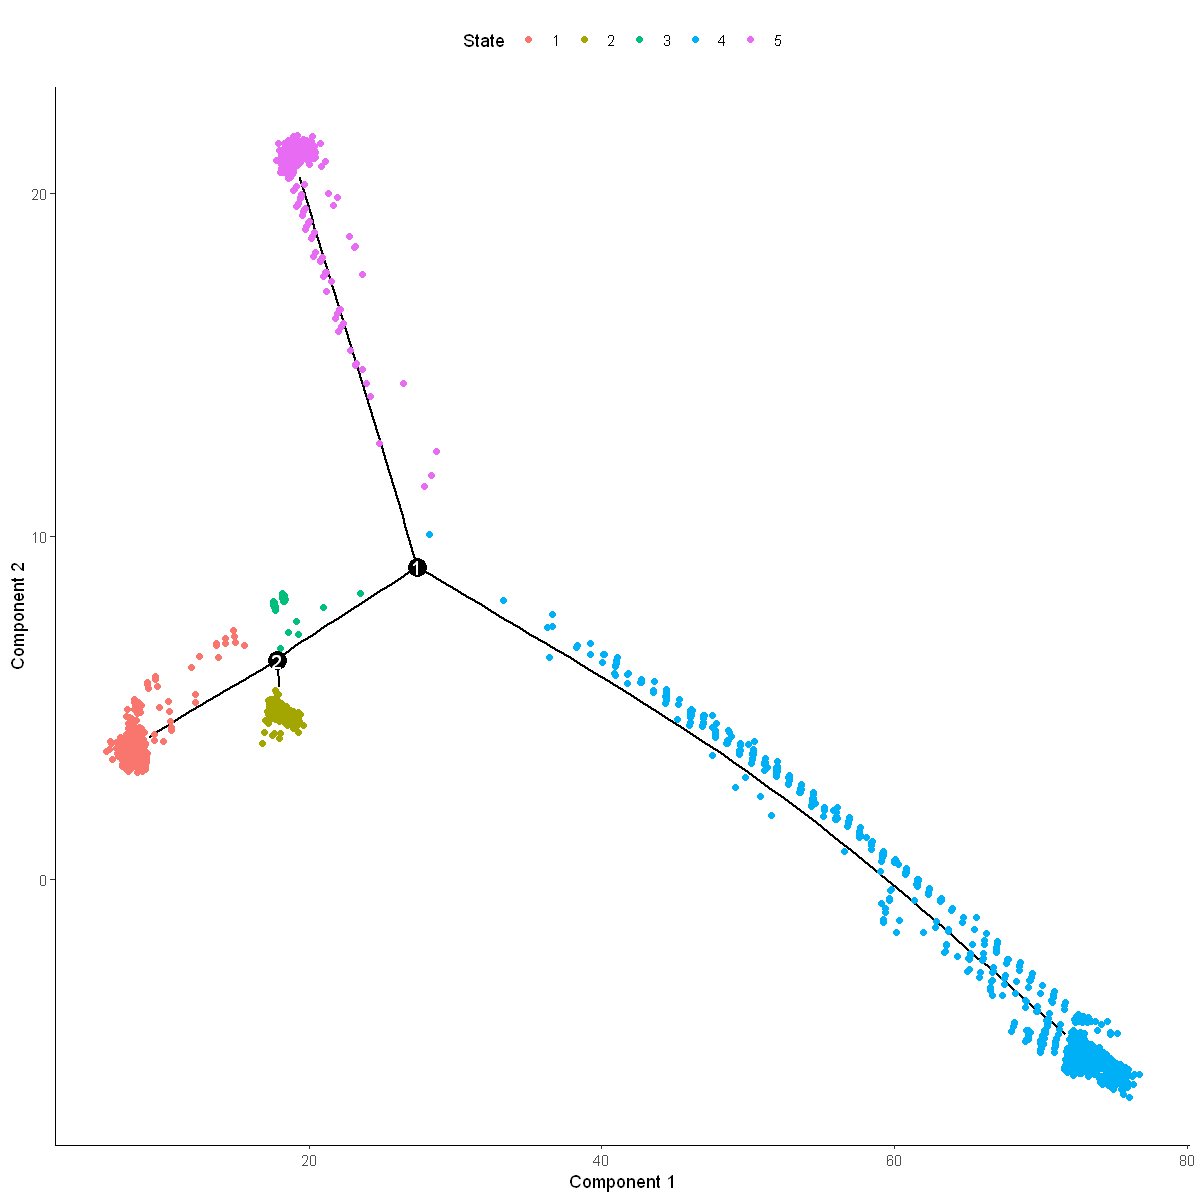

In [127]:
options(repr.plot.width=10, repr.plot.height=10)
plot_cell_trajectory(monocleobject, color_by = "State")

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Windows字体数据库里没有这样的字体系列"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Windows字体数据库里没有这样的字体系列"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Windows字体数据库里没有这样的字体系列"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Windows字体数据库里没有这样的字体系列"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Windows字体数据库里没有这样的字体系列"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Windows字体数据库里没有这样的字体系列"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Windows字体数据库里没有这样的字体系列"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Windows字体数据库里没有这样的字体系列"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Windows字体数据库里没有这样的字体系列"
Warning message in grid.Call.graphics

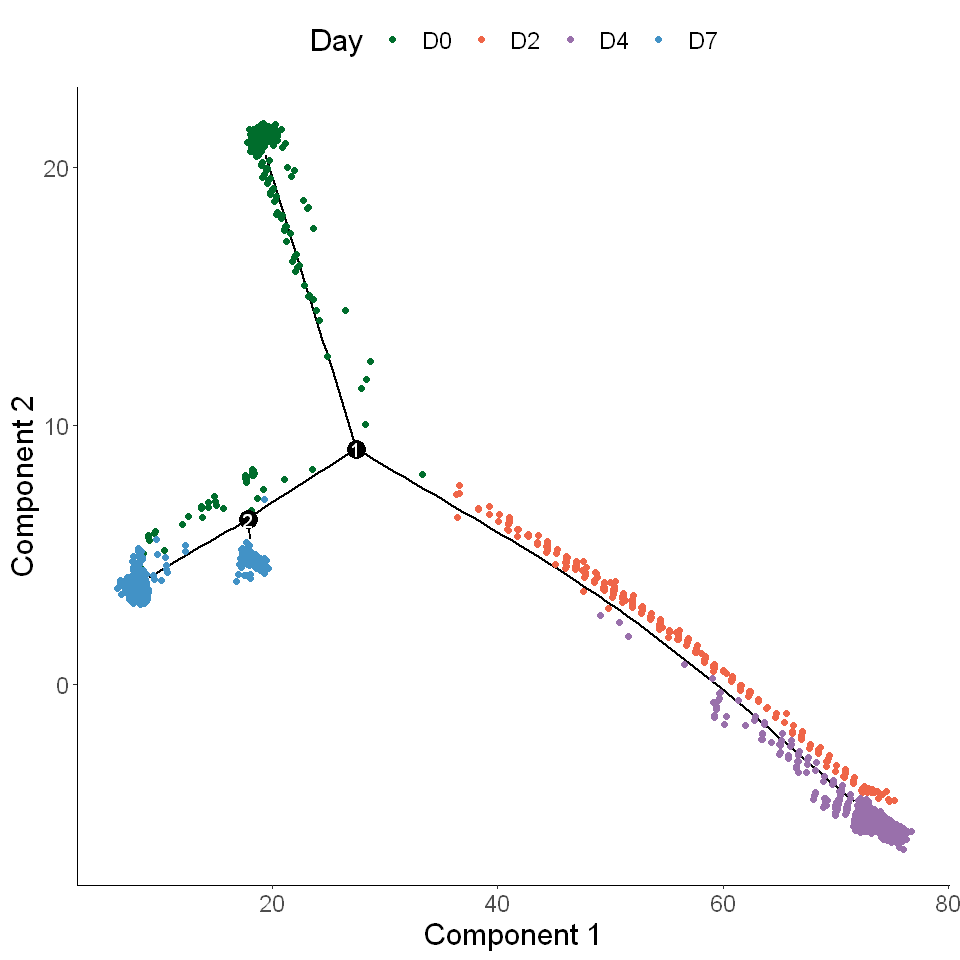

In [159]:
options(repr.plot.width=8, repr.plot.height=8)
# '#810f7c','#fec44f','#dd3497','#993404', '#35978f', '#2171b5'
plot_cell_trajectory(monocleobject, 
                     color_by = "Day",cell_size=1.5)+scale_color_manual(breaks = c('D0', 'D2', 'D4', 'D7'), 
                                                                              values=c( '#006d2c','#ef6548','#9970ab','#4292c6'))+ theme(text=element_text(size=18,  family='DejaVu Sans'))

In [156]:
library(extrafont)

#font_import(path="D:\\ruanjian\\anaconda\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf")

In [158]:
fonts()

[1] "Agency FB"                       "Algerian"                       
  [3] "Arial Black"                     "Arial"                          
  [5] "Arial Narrow"                    "Arial Rounded MT Bold"          
  [7] "Bahnschrift"                     "Baskerville Old Face"           
  [9] "Bauhaus 93"                      "Bell MT"                        
 [11] "Berlin Sans FB"                  "Berlin Sans FB Demi"            
 [13] "Bernard MT Condensed"            "Blackadder ITC"                 
 [15] "Bodoni MT"                       "Bodoni MT Black"                
 [17] "Bodoni MT Condensed"             "Bodoni MT Poster Compressed"    
 [19] "Book Antiqua"                    "Bookman Old Style"              
 [21] "Bookshelf Symbol 7"              "Bradley Hand ITC"               
 [23] "Britannic Bold"                  "Broadway"                       
 [25] "Brush Script MT"                 "Calibri"                        
 [27] "Calibri Light"                   "Californian FB"                 
 [29] "Calisto MT"                      "Cambria"                        
 [31] "Candara"                         "Candara Light"                  
 [33] "Castellar"                       "Centaur"                        
 [35] "Century"                         "Century Gothic"                 
 [37] "Century Schoolbook"              "Chiller"                        
 [39] "Colonna MT"                      "Comic Sans MS"                  
 [41] "Consolas"                        "Constantia"                     
 [43] "Cooper Black"                    "Copperplate Gothic Bold"        
 [45] "Copperplate Gothic Light"        "Corbel"                         
 [47] "Corbel Light"                    "Courier New"                    
 [49] "Curlz MT"                        "DejaVu Sans Mono"               
 [51] "DengXian"                        "DengXian Light"                 
 [53] "Dubai"                           "Dubai Light"                    
 [55] "Dubai Medium"                    "Ebrima"                         
 [57] "Edwardian Script ITC"            "Elephant"                       
 [59] "Engravers MT"                    "Eras Bold ITC"                  
 [61] "Eras Demi ITC"                   "Eras Light ITC"                 
 [63] "Eras Medium ITC"                 "FangSong"                       
 [65] "Felix Titling"                   "Footlight MT Light"             
 [67] "Forte"                           "Franklin Gothic Book"           
 [69] "Franklin Gothic Demi"            "Franklin Gothic Demi Cond"      
 [71] "Franklin Gothic Heavy"           "Franklin Gothic Medium"         
 [73] "Franklin Gothic Medium Cond"     "Freestyle Script"               
 [75] "French Script MT"                "FZShuTi"                        
 [77] "FZYaoTi"                         "Gabriola"                       
 [79] "Gadugi"                          "Garamond"                       
 [81] "Georgia"                         "Gigi"                           
 [83] "Gill Sans Ultra Bold"            "Gill Sans Ultra Bold Condensed" 
 [85] "Gill Sans MT"                    "Gill Sans MT Condensed"         
 [87] "Gill Sans MT Ext Condensed Bold" "Gloucester MT Extra Condensed"  
 [89] "Goudy Old Style"                 "Goudy Stout"                    
 [91] "Haettenschweiler"                "Harlow Solid Italic"            
 [93] "Harrington"                      "HGB1_CNKI"                      
 [95] "HGB1X_CNKI"                      "HGB2_CNKI"                      
 [97] "HGB2X_CNKI"                      "HGB3_CNKI"                      
 [99] "HGB3X_CNKI"                      "HGB4_CNKI"                      
[101] "HGB4X_CNKI"                      "HGB5_CNKI"                      
[103] "HGB5X_CNKI"                      "HGB6_CNKI"                      
[105] "HGB6X_CNKI"                      "HGB7_CNKI"                      
[107] "HGB7X_CNKI"                      "HGB8_CNKI"                      
[109] 